In [52]:
# imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime, timedelta
import seaborn as sns
import scipy as sp
import matplotlib.dates as md
from multiprocessing import  Pool

In [2]:
# load the dataset and observe the data
df = pd.read_csv(r'sales_train.csv')
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


---

1. EDA: first look, statistics and plots

1.1 Statistics

In [3]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [4]:
df.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

1.2 Examine train and test set

In [5]:
df_test = pd.read_csv('test.csv')
missing_shops = [s for s in df_test["shop_id"].unique() if s not in df["shop_id"].unique()]
print('Number of shops that exist in the test set but not in the train set = ',len(missing_shops))
missing_items = [i for i in df_test["item_id"].unique() if i not in df["item_id"].unique()]
print('Number of items that exist in the test set but not in the train set = ',len(missing_items))

Number of shops that exist in the test set but not in the train set =  0
Number of items that exist in the test set but not in the train set =  363


----------------------report-----------------------------------------
📝 What have we got so far? 📝
- We have 60 shops in our training dataset and 42 shops in our test dataset.
- We have 21807 distinct items in our training dataset and 5100 distinct items in our test dataset.
- All the shops in our test dataset are also in our training dataset.
- 363 items in our test dataset are not included in our train_df >> This also means that we do not have the price for these items. (solution: use the category to make some predictions)

1.3 Missing values

In [6]:
# 1st approach: find missing values
print(df.isnull().sum())

# 2nd approach: find missing values (enhanced version)
missing_values = ['n/a','na','missing','nan','']
df_temp = pd.read_csv(r'sales_train.csv', na_values=missing_values)
missing_data = df_temp.isnull()
# missing_data.head()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print('-----------')

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
date
False    2935849
Name: date, dtype: int64
-----------
date_block_num
False    2935849
Name: date_block_num, dtype: int64
-----------
shop_id
False    2935849
Name: shop_id, dtype: int64
-----------
item_id
False    2935849
Name: item_id, dtype: int64
-----------
item_price
False    2935849
Name: item_price, dtype: int64
-----------
item_cnt_day
False    2935849
Name: item_cnt_day, dtype: int64
-----------


1.4 Checking for errors in columns

In [14]:
#date,date_block_num,shop_id,item_id,item_price,item_cnt_day

print('df["date_block_num"].unique() = {}, with length = {}'.format(df['date_block_num'].unique(),len(df['date_block_num'].unique())))
print('-------------------------------------------------------------')
print('df["shop_id"].unique() = {}, with length = {}'.format(sorted(df['shop_id'].unique()),len(df['shop_id'].unique())))
print('-------------------------------------------------------------')
print('df["item_id"].unique() = {}, with length = {} and (min,max)=({},{})'.format(df['item_id'].unique(),len(df['item_id'].unique()), min(df['item_id'].unique()),max(df['item_id'].unique())))
print('-------------------------------------------------------------')
print('df["item_cnt_day"].unique() = {}'.format(df['item_cnt_day'].unique()))
print('-------------------------------------------------------------')

df["date_block_num"].unique() = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33], with length = 34
-------------------------------------------------------------
df["shop_id"].unique() = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], with length = 60
-------------------------------------------------------------
df["item_id"].unique() = [22154  2552  2554 ...  7610  7635  7640], with length = 21807 and (min,max)=(0,22169)
-------------------------------------------------------------
df["item_cnt_day"].unique() = [ 1.000e+00 -1.000e+00  3.000e+00  2.000e+00  4.000e+00  5.000e+00
  1.300e+01  7.000e+00  6.000e+00  8.000e+00  1.000e+01  1.100e+01
  3.000e+01  2.200e+01  1.400e+01  1.500e+01  9.000e+00  1.200e+01
  1.700e+01  1.900e+01  2.000e+01 -5.000e+

----------------------report-----------------------------------------

- Negative values in item_cnt_day column! Probably because of returned items or human error (possible solutions: zero or absolute value for these)

In [6]:
# delete negative value in column 'item_price' (it is an outlier) 
# df['item_price'].lt(0).sum()
print(sum(df['item_price']<0))
df_negative = df.index[df['item_price'] < 0]
print(df_negative)

1
Int64Index([484683], dtype='int64')


In [7]:
df.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price              -1.0
item_cnt_day             1.0
Name: 484683, dtype: object

In [8]:
df = df.drop([484683])
df = df.reset_index()

1st approach: replace negative values in column 'item_cnt_day' with zeros

In [9]:
df_backup = df.copy(deep=True)
df.loc[df['item_cnt_day'] < 0,'item_cnt_day'] = 0

2nd approach: replace negative values in column 'item_cnt_day' with their absolute value

In [11]:
# df_neg2pos = df.copy(deep=True)
# df_neg2pos['item_cnt_day']=df_neg2pos['item_cnt_day'].apply(lambda x:abs(x))

1.5 Handling outliers

In [10]:
"""
We will map the top 5% for "item_price" and "item_cnt_day" to the top qualtile value for the following plots. 
(We have seen before that there are some outliers)
"""
for col in ["item_price", "item_cnt_day"]:
    upper_quantile = df[col].quantile(0.95)
    df[col] = np.where(df[col]>upper_quantile, upper_quantile,df[col])

"""
Furthermore, let us create a column for the actual turnover per item.
"""
df["sales_per_item"] = df["item_price"] * df["item_cnt_day"]

Text(0.5, 0.98, 'Analysis per Item per Day')

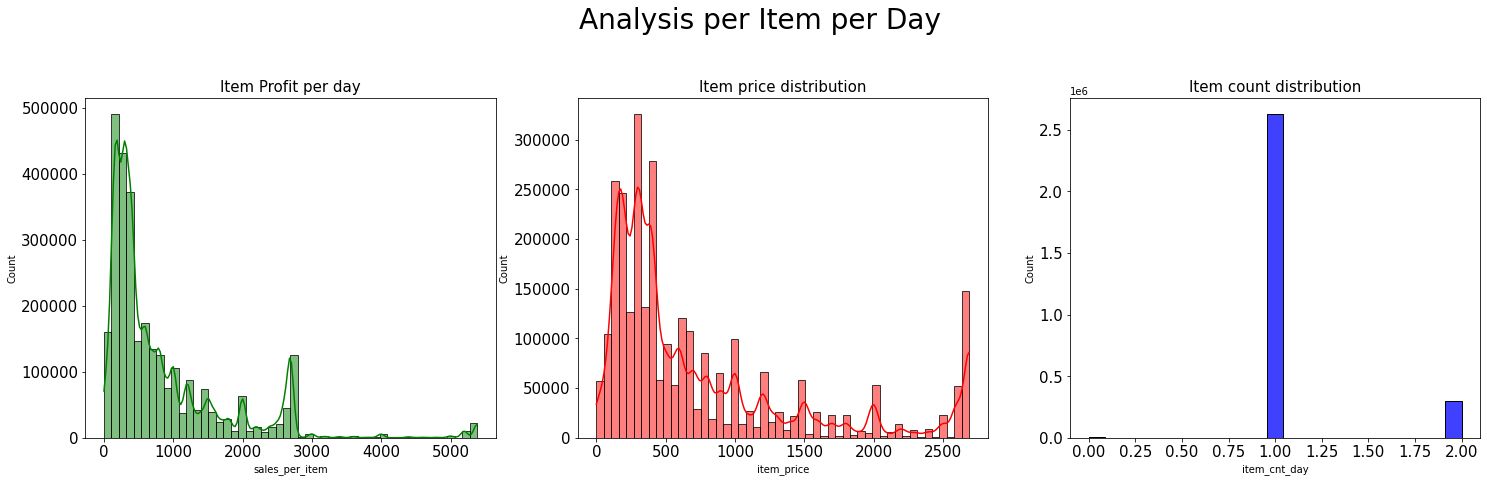

In [11]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])
ax00.tick_params(axis='both', labelsize=15)
ax01.tick_params(axis='both', labelsize=15)
ax02.tick_params(axis='both', labelsize=15)
ax00.set_title('Item Profit per day', fontsize=15)
ax01.set_title('Item price distribution', fontsize=15)
ax02.set_title('Item count distribution', fontsize=15)
sns.histplot(data = df ,x="sales_per_item", kde=True, bins=50 , color='green',ax=ax00)
sns.histplot(data = df ,x="item_price", kde=True, bins=50, color='red', ax=ax01)
sns.histplot(data = df ,x="item_cnt_day", kde=False, color='blue', ax=ax02)

fig.subplots_adjust(top=0.8)
fig.suptitle('Analysis per Item per Day', fontsize="28")

------------------------report-------------------------
- most items are sold once per day and not more.

1.6 Overall sales per month

In [12]:
m_df = df.copy()
"""
Fist we need to cast date to datetime and then we can use all the sweet ".dt"-features
""" 
m_df['date']= pd.to_datetime(m_df['date'])
m_df["month"] = m_df["date"].dt.month
m_df["year"] = m_df["date"].dt.year
m_df['date'] = pd.to_datetime(m_df[['year', 'month']].assign(DAY=28)) # workaround for end of month (its just for the visuals so we should be ok here)
m_df = m_df[["date", "item_cnt_day", "sales_per_item"]].groupby("date").sum().reset_index()
m_df.rename(columns ={"item_cnt_day": "item_cnt_month", "sales_per_item": "sales_per_month"}, inplace=True)
m_df

C:\Users\User\AppData\Local\Temp\ipykernel_5444\2327870642.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  m_df['date']= pd.to_datetime(m_df['date'])


,date,item_cnt_month,sales_per_month
0,2013-01-28,109835.0,6.825886e+07
1,2013-02-28,122813.0,7.795040e+07
2,2013-03-28,127784.0,8.224101e+07
3,2013-04-28,103747.0,6.306095e+07
4,2013-05-28,102492.0,6.337802e+07
5,2013-06-28,110940.0,6.844616e+07
6,2013-07-28,118082.0,6.905113e+07
7,2013-08-28,119898.0,7.146120e+07
8,2013-09-28,110487.0,7.490957e+07
9,2013-10-28,105542.0,7.224703e+07


C:\Users\User\AppData\Local\Temp\ipykernel_5444\159959197.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=m_df, y="sales_per_month", x = "date", palette="tab10", linewidth=5, ax=ax0, label="sales_per_month")
C:\Users\User\AppData\Local\Temp\ipykernel_5444\159959197.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=m_df, y="item_cnt_month", x = "date", palette="tab10", linewidth=5, ax=ax1, label="item_cnt_month")


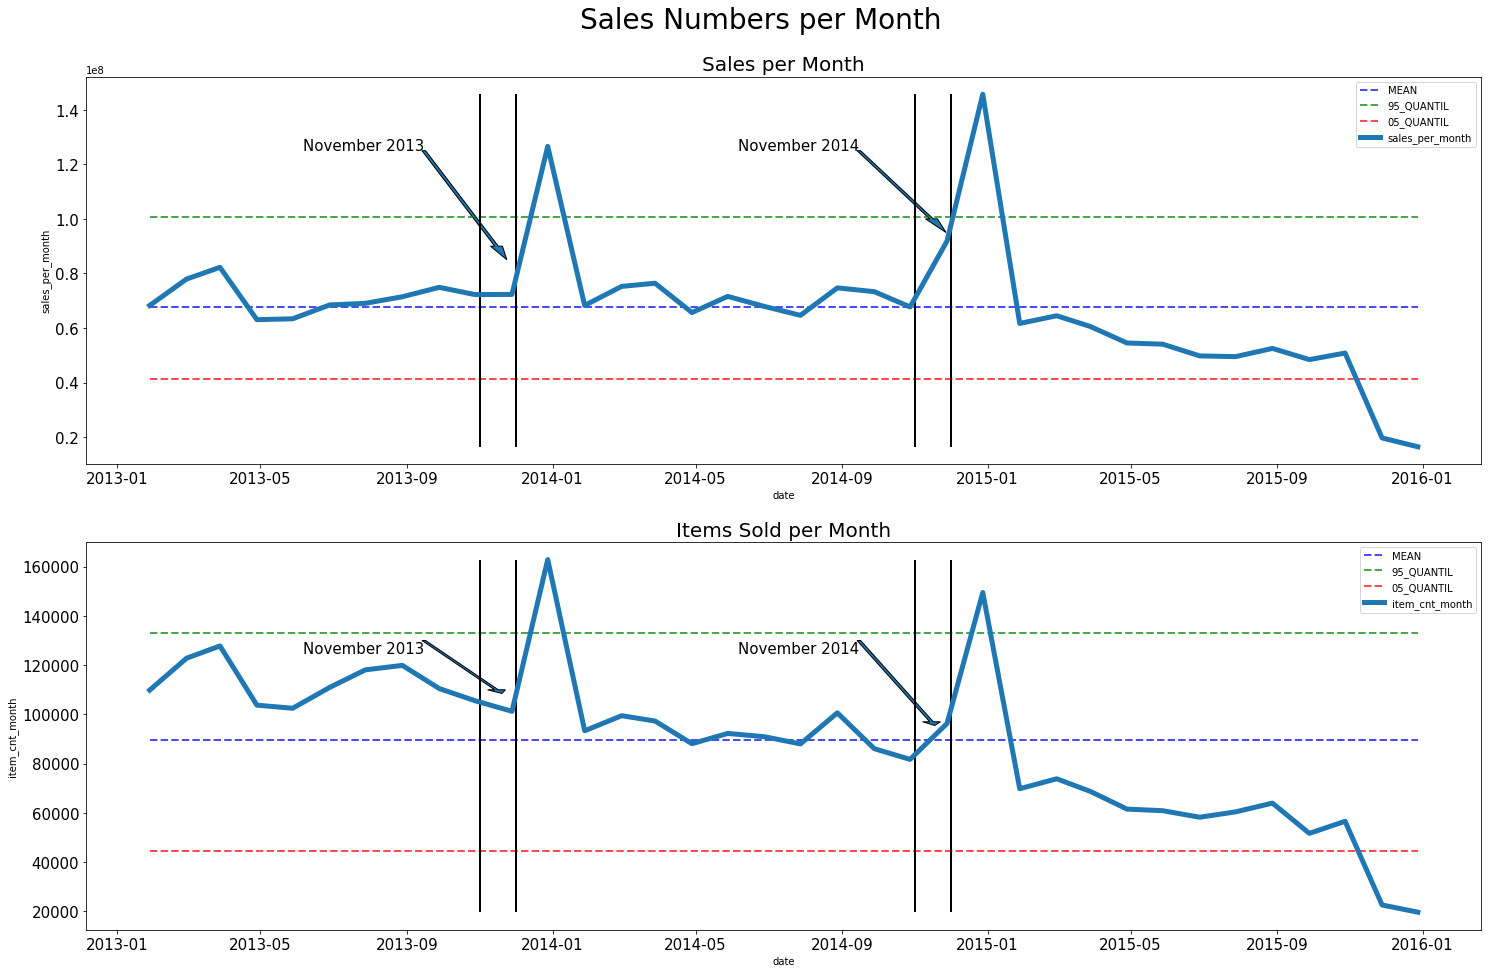

In [13]:
fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(2, 1)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sales per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)

# adding hrozontal lines
ax0.hlines(y=m_df["sales_per_month"].mean(), color='b', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="MEAN") 
ax0.hlines(y=m_df["sales_per_month"].quantile(0.95), color='g', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="95_QUANTIL") 
ax0.hlines(y=m_df["sales_per_month"].quantile(0.05), color='r', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="05_QUANTIL")
ax1.hlines(y=m_df["item_cnt_month"].mean(), color='b', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="MEAN") 
ax1.hlines(y=m_df["item_cnt_month"].quantile(0.95), color='g', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="95_QUANTIL") 
ax1.hlines(y=m_df["item_cnt_month"].quantile(0.05), color='r', linewidth=2, alpha=.7, ls='--', xmin=m_df["date"].min() , xmax = m_df["date"].max(), label="05_QUANTIL")

# adding vertical lines
ax0.vlines(x=datetime.strptime("2013-11-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2013-12-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2014-11-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax0.vlines(x=datetime.strptime("2014-12-01", "%Y-%m-%d"), ymin=m_df["sales_per_month"].min(), ymax=m_df["sales_per_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2013-11-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2013-12-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2014-11-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)
ax1.vlines(x=datetime.strptime("2014-12-01", "%Y-%m-%d"), ymin=m_df["item_cnt_month"].min(), ymax=m_df["item_cnt_month"].max(), color="black", linewidth=2)

# adding some arrows (this can be a bit trickt and frustrating ;) )
style = dict(size=15, color='black')

x_date_1 = md.date2num(datetime.strptime("2013-9-15", "%Y-%m-%d"))
x_date_1_dt = md.date2num(datetime.strptime("2013-11-15", "%Y-%m-%d")) - x_date_1
x_date_2 = md.date2num(datetime.strptime("2014-9-15", "%Y-%m-%d"))
x_date_2_dt = md.date2num(datetime.strptime("2014-11-15", "%Y-%m-%d")) - x_date_2

ax0.arrow(x_date_1, 125000000, x_date_1_dt, -35000000, head_width=10, head_length=5000000, width=3)
ax0.text(x_date_1, 125000000, "November 2013", ha='right', **style)
ax0.arrow(x_date_2, 125000000, x_date_2_dt, -25000000, head_width=10, head_length=5000000, width=3)
ax0.text( x_date_2, 125000000, "November 2014", ha='right', **style)

ax1.arrow(x_date_1, 130000, x_date_1_dt, -20000, head_width=15, head_length=1500, width=3)
ax1.text(x_date_1, 125000, "November 2013", ha='right', **style)
ax1.arrow(x_date_2, 130000, x_date_2_dt, -33000, head_width=15, head_length=1500, width=3)
ax1.text( x_date_2, 125000, "November 2014", ha='right', **style)


sns.lineplot(data=m_df, y="sales_per_month", x = "date", palette="tab10", linewidth=5, ax=ax0, label="sales_per_month")
sns.lineplot(data=m_df, y="item_cnt_month", x = "date", palette="tab10", linewidth=5, ax=ax1, label="item_cnt_month")
fig.subplots_adjust(top=0.915)
fig.suptitle('Sales Numbers per Month', fontsize="28")
plt.legend()

C:\Users\User\AppData\Local\Temp\ipykernel_5444\1917156958.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=m_df[m_df["date"].dt.year == 2013], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2013")
C:\Users\User\AppData\Local\Temp\ipykernel_5444\1917156958.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=m_df[m_df["date"].dt.year == 2014], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2014")
C:\Users\User\AppData\Local\Temp\ipykernel_5444\1917156958.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=m_df[m_df["date"].dt.year == 2015], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2015")
C:\Users\User\AppData\Local\Temp\ipykernel_5444\1917156958.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.linep

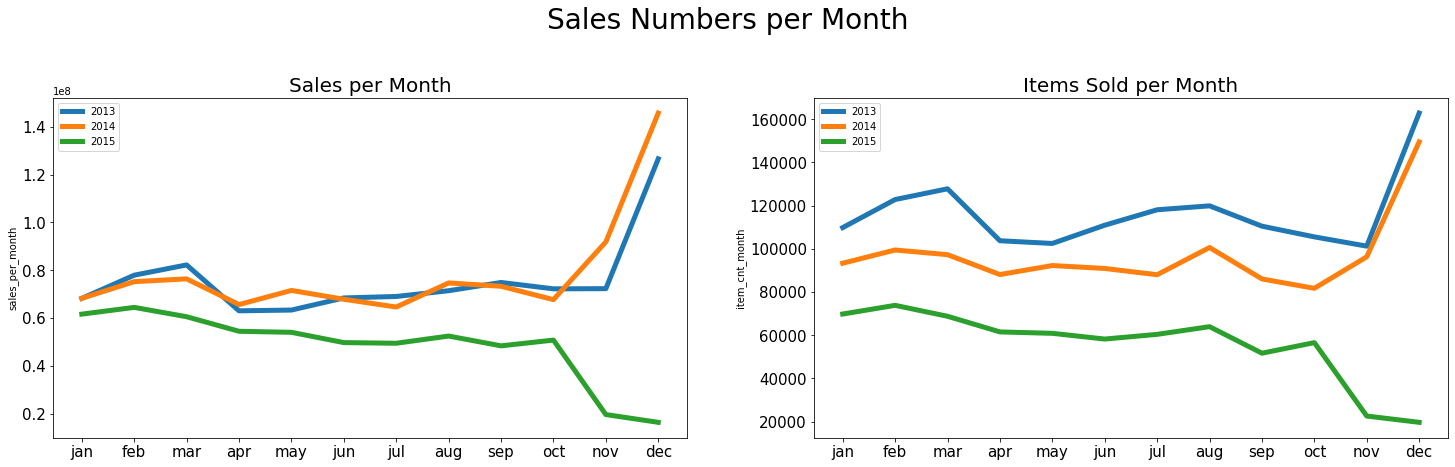

In [14]:
fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sales per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)
"""
Tip: See how we can use the .dt property since "date" is a datetime column. 
     You can also replace the x-values as described below.
"""
month_ = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
sns.lineplot(data=m_df[m_df["date"].dt.year == 2013], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2013")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2014], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2014")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2015], y="sales_per_month", x=month_, palette="tab10", linewidth=5, ax=ax0, label="2015")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2013], y="item_cnt_month", x=month_, palette="tab10", linewidth=5, ax=ax1, label="2013")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2014], y="item_cnt_month", x=month_, palette="tab10", linewidth=5, ax=ax1, label="2014")
sns.lineplot(data=m_df[m_df["date"].dt.year == 2015], y="item_cnt_month", x=month_, palette="tab10", linewidth=5, ax=ax1, label="2015")
fig.subplots_adjust(top=0.8)
fig.suptitle('Sales Numbers per Month', fontsize="28")
ax0.legend()
ax1.legend()

--------------------------report-----------------------------

 What we can see is that there is an overall decline in the number of items sold per month, even though the sales figures for 2013 and 214 are quite similar. This means that people tend to buy fewer but more expensive items. Also, we can now see how weak the sales figures for 2015 look compared to the previous two years.
Previously we took a closer look at the individual item categories, let's wrap this section up by taking a closer look at the individual shops. I don't think we will see anything surprising in the sales figures per shop, but it is always advisable to look at the whole dataset before moving on to preprocessing and modelling.

1.7 Shop analysis

In [15]:
"""
We do the same as before, but now we also add the shot_id in our groupby-step.

As always, if you have any questions about the code, feel free to ask them in the comments section.
The same goes for suggestions for improvements ofcorse!
"""
m_shop_df = df.copy()

m_shop_df['date']= pd.to_datetime(m_shop_df['date'])
m_shop_df["month"] = m_shop_df["date"].dt.month
m_shop_df["year"] = m_shop_df["date"].dt.year
m_shop_df['date'] = pd.to_datetime(m_shop_df[['year', 'month']].assign(DAY=28)) # workaround for end of month (its just for the visuals so we should be ok here)
m_shop_df = m_shop_df[["date", "item_cnt_day", "sales_per_item", "shop_id"]].groupby(["date", "shop_id"]).sum().reset_index()
m_shop_df.rename(columns ={"item_cnt_day": "item_cnt_month", "sales_per_item": "sales_per_month"}, inplace=True)
m_shop_df

C:\Users\User\AppData\Local\Temp\ipykernel_5444\1495777551.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  m_shop_df['date']= pd.to_datetime(m_shop_df['date'])


,date,shop_id,item_cnt_month,sales_per_month
0,2013-01-28,0,3491.0,1.579077e+06
1,2013-01-28,1,1903.0,8.122970e+05
2,2013-01-28,2,734.0,6.153491e+05
3,2013-01-28,3,667.0,4.596640e+05
4,2013-01-28,4,1643.0,1.037817e+06
...,...,...,...,...
1842,2015-12-28,55,531.0,3.864950e+05
1843,2015-12-28,56,435.0,2.946515e+05
1844,2015-12-28,57,689.0,4.957932e+05
1845,2015-12-28,58,553.0,4.224590e+05


Text(0.5, 0.98, 'Sales Numbers per Month and Shop')

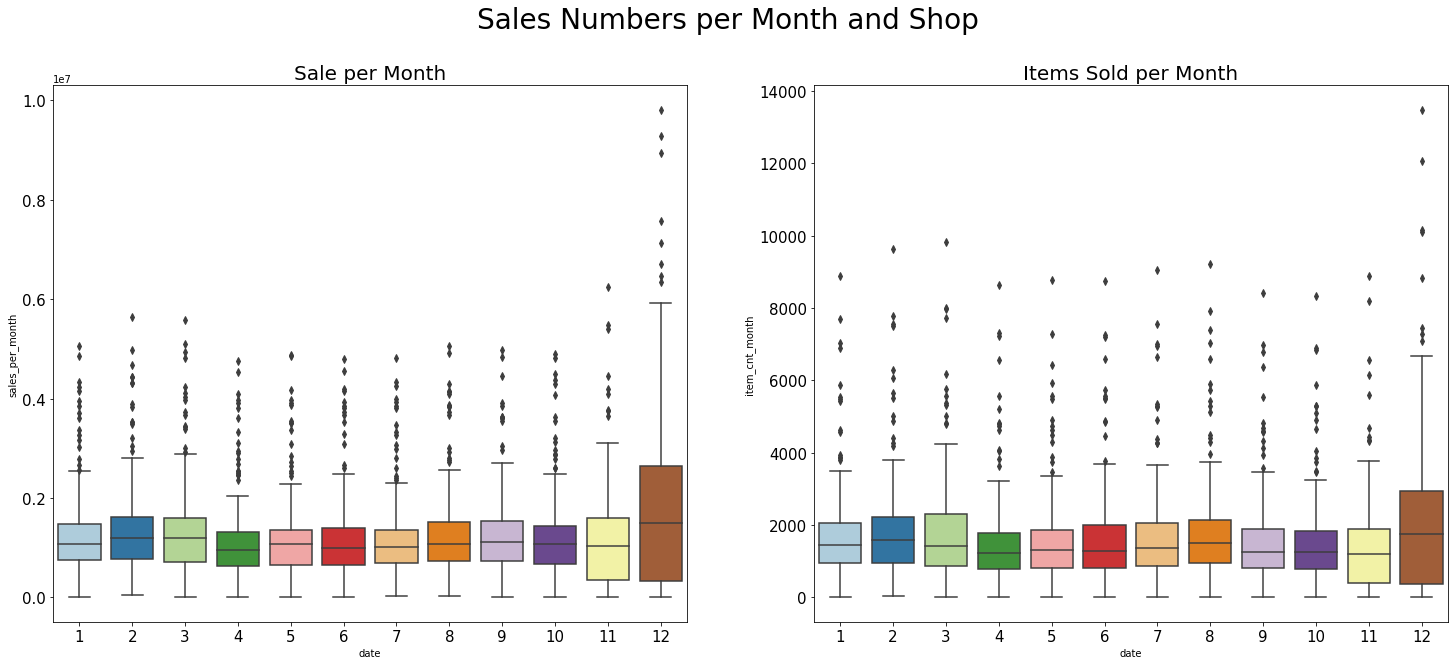

In [16]:
fig = plt.figure(figsize=(25,10))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax0.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax0.set_title('Sale per Month', fontsize=20)
ax1.set_title('Items Sold per Month', fontsize=20)
sns.boxplot(x=m_shop_df["date"].dt.month, y="sales_per_month", data=m_shop_df, ax=ax0, palette="Paired")
sns.boxplot(x=m_shop_df["date"].dt.month, y="item_cnt_month", data=m_shop_df, ax=ax1, palette="Paired")
fig.subplots_adjust(top=0.87)
fig.suptitle('Sales Numbers per Month and Shop', fontsize="28")

In [23]:
m_shop_df.shape

(1847, 4)

In [18]:
"""
Create a data dataframe with some basic information about our 60 shops:
"""
shops_df = pd.read_csv('shops.csv')
df = pd.read_csv('sales_train.csv')
shop_info_df = pd.DataFrame(columns=["shop_name", "num_products", "fist_business_m", "last_business_m",
                                     "min_price", "max_price", "mean_price", "median_price", "mean_sales_pm", "median_sales_pm"],
                            index = m_shop_df["shop_id"].unique())

for sid in m_shop_df["shop_id"].unique():
    shop_info_df.at[sid, "shop_name"] = shops_df[shops_df["shop_id"]==sid]["shop_name"].values[0]
    shop_info_df.at[sid, "num_products"] = df[df["shop_id"]==sid]["item_id"].nunique()
    sdf= m_shop_df[m_shop_df["shop_id"]==sid]
    shop_info_df.at[sid, "fist_business_m"] = sdf["date"].min()
    shop_info_df.at[sid, "last_business_m"] = sdf["date"].max()
    shop_info_df.at[sid, "min_price"] = df[df["shop_id"]==sid]["item_price"].min()
    shop_info_df.at[sid, "max_price"] = df[df["shop_id"]==sid]["item_price"].max()
    shop_info_df.at[sid, "mean_price"] = df[df["shop_id"]==sid]["item_price"].mean()
    shop_info_df.at[sid, "median_price"] = df[df["shop_id"]==sid]["item_price"].median()
    shop_info_df.at[sid, "mean_sales_pm"] = sdf["sales_per_month"].median()
    shop_info_df.at[sid, "median_sales_pm"] = sdf["sales_per_month"].median()
    """
    We will do it a little bit different for this shop dataframe. Here, the average turnover per month would
    not be so interesting.Instead, we can use our m_shop_df for the sales figures per month.
    """
# changing datatypes from object to datetime float and int:
shop_info_df['fist_business_m']= pd.to_datetime(shop_info_df['fist_business_m'])
shop_info_df['last_business_m']= pd.to_datetime(shop_info_df['last_business_m'])
shop_info_df["fist_business_m"] = shop_info_df["fist_business_m"].dt.strftime("%Y-%m")
shop_info_df["last_business_m"] = shop_info_df["last_business_m"].dt.strftime("%Y-%m")
shop_info_df = shop_info_df.astype({'num_products': 'int32',
                                    "min_price": 'float32',
                                    "max_price": 'float32',
                                    "mean_price": 'float32',
                                    "median_price": 'float32',
                                    "mean_sales_pm": 'float32',
                                    "median_sales_pm": 'float32'})

In [27]:
df_shops_merge = pd.merge(m_shop_df, shop_info_df, how ='inner', on ='shop_id')

In [44]:
df_shops_merge["month"] = df_shops_merge["date"].dt.month
df_shops_merge["year"] = df_shops_merge["date"].dt.year
df_shops_merge['date_year_month'] = pd.to_datetime(df_shops_merge[['year', 'month']].assign(DAY=28))

C:\Users\User\AppData\Local\Temp\ipykernel_5444\239314062.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax11)
C:\Users\User\AppData\Local\Temp\ipykernel_5444\239314062.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax11)
C:\Users\User\AppData\Local\Temp\ipykernel_5444\239314062.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax10)
C:\Users\User\AppData\Local\Temp\ipykernel_5444\239314062.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax10)
C:\Users\User\AppData\Local\Temp\ipykernel_5444\23931406

Text(0.5, 0.98, 'Turnover Trend for Each Item Category')

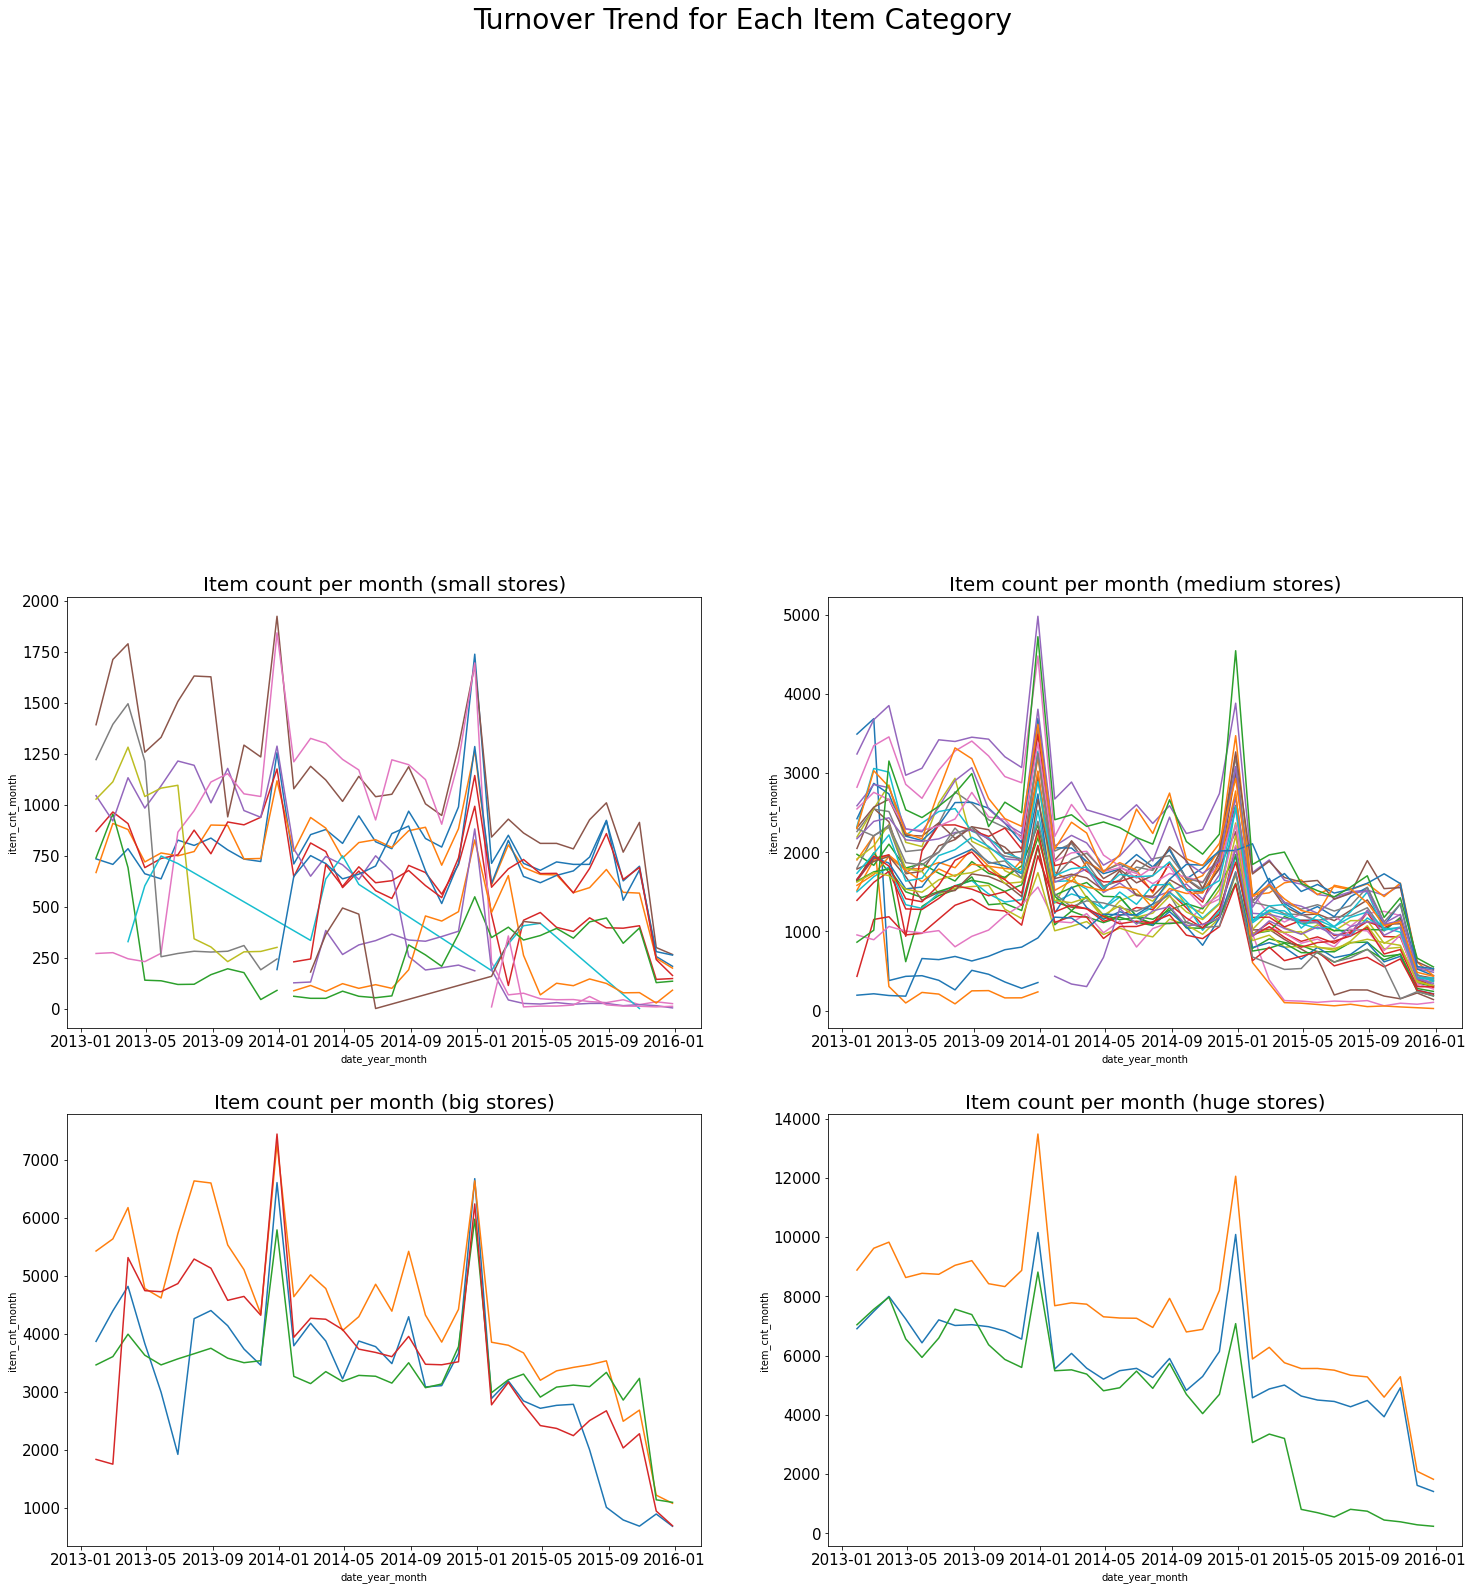

In [50]:
fig = plt.figure(figsize=(25,25))
gs = fig.add_gridspec(3, 2)
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1])
ax10.tick_params(axis='both', labelsize=15)
ax11.tick_params(axis='both', labelsize=15)
ax20.tick_params(axis='both', labelsize=15)
ax21.tick_params(axis='both', labelsize=15)
ax10.set_title('Item count per month (small stores)', fontsize=20)
ax11.set_title('Item count per month (medium stores)', fontsize=20)
ax20.set_title('Item count per month (big stores)', fontsize=20)
ax21.set_title('Item count per month (huge stores)', fontsize=20)

"""
Plot each category, depending on its max item_cnt_month:
"""

for c in df_shops_merge["shop_id"].unique():
    tmp_df = df_shops_merge[df_shops_merge["shop_id"]==c].copy()
    max_count = tmp_df["item_cnt_month"].max()
    if max_count < 2000:
        sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax10)
    elif 2000 <= max_count < 5000 :
        sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax11)
    elif 5000 <= max_count < 8000 :
        sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax20)
    else: 
        # > 8000
        sns.lineplot(x="date_year_month", y="item_cnt_month", data=tmp_df, palette="Set2", ax=ax21)          
plt.legend([],[], frameon=False)
fig.subplots_adjust(top=0.94)
fig.suptitle('Turnover Trend for Each Item Category', fontsize="28")

---

2. Data Preparation

In [51]:
def preprocessing(data = pd.read_csv('sales_train.csv'), item_data=pd.read_csv('items.csv'), shop_data=pd.read_csv('shops.csv'), category_data=pd.read_csv('item_categories.csv')):
    """
    Some basic stuff.
    """ 
    print(50*'-')
    print("preprocessing...")
    # 1). Create a copy of the Dataframe.
    df = data.copy()
    # 2). Remove all values with item_cnt_day < 1.
    df = df[df["item_cnt_day"]>0]
    #3). Add Month feature
    df["date"]= pd.to_datetime(df["date"], format='%d.%m.%Y')
    df["month"] = df["date"].dt.month
    #4). Group by date_block_num.
    df = df[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(
        ["date_block_num", "shop_id", "item_id"]).agg(
        {"item_price": "mean","item_cnt_day": "sum", "month": "min"}).reset_index()
    df.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
    #5). Add category_id and item_name.
    df = pd.merge(df, item_data, on="item_id", how="inner")
    #6). Add shop_name 
    df = pd.merge(df, shop_data, on="shop_id", how="inner")
    #7). Add category_name
    df = pd.merge(df, category_data, on="item_category_id", how="inner")
    print("done.")
    print(50*'-')
    return df

piped_df = preprocessing()
piped_df.head()

--------------------------------------------------
preprocessing...
done.
--------------------------------------------------


,date_block_num,shop_id,item_id,item_price,item_cnt_month,month,item_name,item_category_id,shop_name,item_category_name
0,0,0,32,221.0,6.0,1,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
1,1,0,32,221.0,10.0,2,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
2,0,0,35,247.0,1.0,1,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
3,1,0,35,247.0,14.0,2,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD
4,0,0,43,221.0,1.0,1,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD


In [53]:
def add_lag_feature_and_label(args):
    
    def add_lags(df, date_block):
        for lag in range(num_lags):
            if (date_block-lag-1) in item_df["date_block_num"].values:
                lag_value = item_df[item_df["date_block_num"]==date_block-lag-1]["item_cnt_month"].values[0]
                df.at[index, f"lag_{lag+1}"] = lag_value
        return df 
    df = args[0].copy()
    num_lags = args[1]
    target_date_block = args[2]
    for lag in range(num_lags):
        df[f"lag_{lag+1}"] = 0
    for shop in df["shop_id"].unique():
        shop_df = df[df["shop_id"]==shop].copy()
        for item in shop_df["item_id"].unique():
            item_df = shop_df[shop_df["item_id"]==item].copy()
            last_index = 0
            for index, row in item_df.iterrows():
                date_block = row["date_block_num"]
                if target_date_block and date_block == target_date_block:
                    df = add_lags(df, date_block)
                if target_date_block is None:
                    df = add_lags(df, date_block)
    if target_date_block:
        df = df[df["date_block_num"]==target_date_block].copy()
    df.rename(columns={"item_cnt_month":"label"}, inplace=True)
    return df

def parallelize_lag_and_target_processing(df, num_lags, target_date_block_num=None, func=add_lag_feature_and_label, n_cores=4, shops=None, items=None):
    if target_date_block_num:
        # get list of valid date_block_num values:
        valid_date_blocks = range(target_date_block_num - num_lags, target_date_block_num + 1)
        df = df[df["date_block_num"].isin(valid_date_blocks)].copy()
    if shops:
        df = df[df["shop_id"].isin(shops)].copy()
    if items:
        df = df[df["item_id"].isin(items).copy()]
    df.sort_values(by="shop_id", inplace=True)
    df_split = np.array_split(df, n_cores)
    param_list = [[df_, num_lags, target_date_block_num] for df_ in df_split]
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, param_list))
    pool.close()
    pool.join()
    return df

In [54]:
"""
Testing add_lag_feature_and_label and parallelize_lag_and_target_processing:
"""
lag_test_df = parallelize_lag_and_target_processing(df=piped_df, shops=[10], num_lags=12, target_date_block_num=24)
# We only need a few columns to validate the result
columns = [col for col in lag_test_df.columns if col[:3]=="lag"]
columns = ["item_id", "date_block_num", "label"] + columns
lag_test_df[columns].head(3)

# Time Series Analysis

- 27/2/2014 russia invaded crimea
- 2014 - 2015 russian financial crisis
- October -> russian october revolution (e.g 20)
- (some shops opened for just one month e.g. 11)

In [30]:
df.groupby(by='shop_id')['item_cnt_day'].count()

shop_id
0       9857
1       5678
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21397
11       499
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
20      1792
21     58133
22     45434
23      6963
24     53032
25    186104
26     53910
27    105366
28    142234
29     49225
30     50860
31    235636
32      7947
33      5027
34      5752
35     58445
36       306
37     39638
38     46013
39     13440
40      4257
41     41967
42    109253
43     39282
44     39530
45     35891
46     66321
47     56695
48     21612
49     15849
50     65173
51     44433
52     43502
53     52921
54    143480
55     34769
56     69573
57    117428
58     71441
59     42108
Name: item_cnt_day, dtype: int64

In [19]:
shop_df = df.groupby(by='shop_id')
shop_df.first()

,date,date_block_num,item_id,item_price,item_cnt_day
shop_id,,,,,
0,12.01.2013,0,11059,73.00,1.0
1,14.01.2013,0,8070,137.00,1.0
2,14.01.2013,0,11330,149.00,1.0
3,26.01.2013,0,13102,1290.00,1.0
4,12.01.2013,0,5605,489.30,1.0
5,21.02.2013,1,2750,2499.00,1.0
6,03.01.2013,0,32,349.00,1.0
7,09.01.2013,0,2441,1199.00,1.0
8,21.01.2013,0,11017,199.00,1.0


In [36]:
shop_df.get_group(54).groupby(by='date_block_num')['item_cnt_day'].count()

date_block_num
0     7526
1     6359
2     7299
3     5553
4     5595
5     6152
6     5755
7     6329
8     5480
9     4990
10    5646
11    7376
12    6327
13    4691
14    5159
15    4122
16    4344
17    4866
18    4323
19    4845
20    3572
21    3706
22    4466
23    5693
24    4855
25    3769
26    4012
27     670
Name: item_cnt_day, dtype: int64

---

REMEMBER
- tackle negative values as positive !!

OBSERVATIONS
- train #shopid = 60 BUT test #shopid = 42
- train #itemid = 21807 BUT test #itemid = 5100